In [1]:
# import fastai
from fastai.vision.all import *

In [2]:
#import os, dotenv, Path
import os
from dotenv import load_dotenv
from pathlib import Path
load_dotenv() 

# Path to dataset
path = Path(os.getenv("DATASET_PATH"))

# DataLoaders with built-in augmentation
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,       # split dataset,train=0.8, valid=0.2
    seed=42,             # reproducibility
    bs=32,               # batch size
    item_tfms=Resize(460, method=ResizeMethod.Squish, pad_mode='zeros'),  #resize 
    batch_tfms=[
        *aug_transforms(  #augmentations
            size= 224,
            do_flip=True,
            flip_vert=False,
            max_rotate=10,
            max_zoom=1.1,
            min_scale=0.9,
            max_warp=0.05,
            p_affine=0.5,
            p_lighting=0.7
            
        ),
        Normalize.from_stats(*imagenet_stats) #normalise
    ]
)

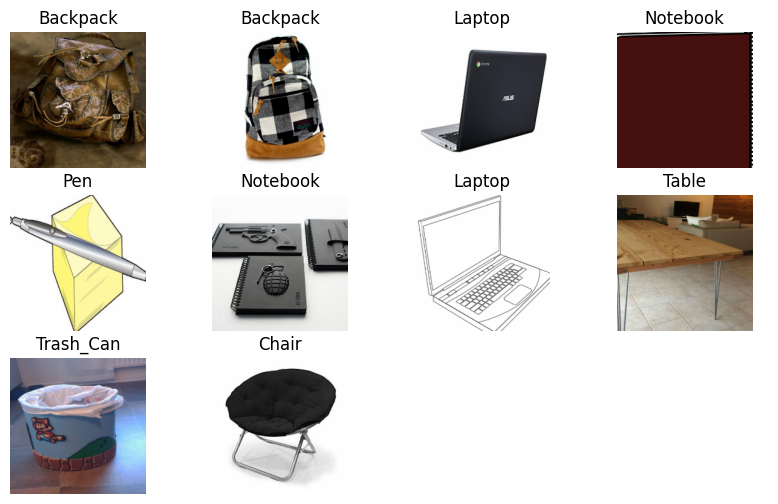

In [3]:
dls.show_batch(max_n=10, figsize=(10,6))

In [4]:
#Create learner
learn = vision_learner(
    dls,
    resnet34,
    metrics=accuracy,
    loss_func=CrossEntropyLossFlat(),
    opt_func=SGD
)


In [5]:
# print classes
print(dls.vocab)

['Backpack', 'Chair', 'File_Cabinet', 'Laptop', 'Mouse', 'Mug', 'Notebook', 'Pen', 'Table', 'Trash_Can']


SuggestedLRs(valley=0.015848932787775993)

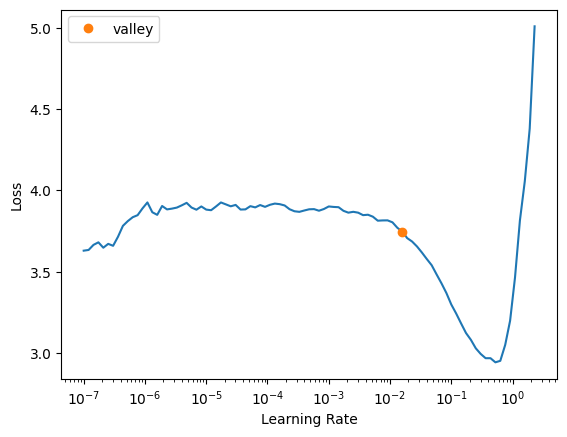

In [6]:
# Find learning rate
learn.lr_find()

Take learning rate of 2e-2, where the valley mark is

In [7]:
# freeze petrained layers
learn.freeze()

# train head for 5 epochs with learning rate of 2e-2
learn.fit_one_cycle(5, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.348839,0.627494,0.804554,04:57
1,1.008561,0.289057,0.910816,06:53
2,0.568298,0.244470,0.920304,07:22
3,0.412945,0.229489,0.929791,09:19
4,0.343909,0.232475,0.924099,06:38


SuggestedLRs(valley=0.0003311311302240938)

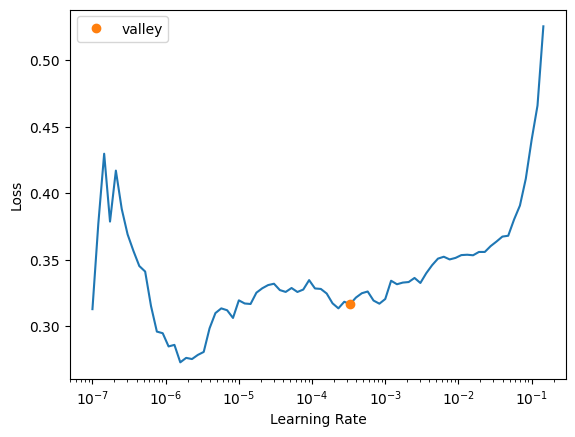

In [8]:
#unfreeze model and find learning rate
learn.unfreeze()
learn.lr_find()


The learning rate range is (1e-6, 1e-3)

In [9]:
# import callback
from fastai.callback.all import *
early_stop = EarlyStoppingCallback(monitor='valid_loss', min_delta=0.001, patience=3)

In [10]:
#fine tune the entire model
learn.fit_one_cycle(6, lr_max=slice(1e-6,1e-3), cbs=[early_stop])

epoch,train_loss,valid_loss,accuracy,time
0,0.305601,0.227699,0.929791,06:06
1,0.312647,0.224670,0.927894,09:03
2,0.305979,0.223862,0.927894,12:36
3,0.321673,0.229665,0.927894,09:25
4,0.305631,0.222188,0.927894,08:19
5,0.313576,0.223145,0.929791,09:38


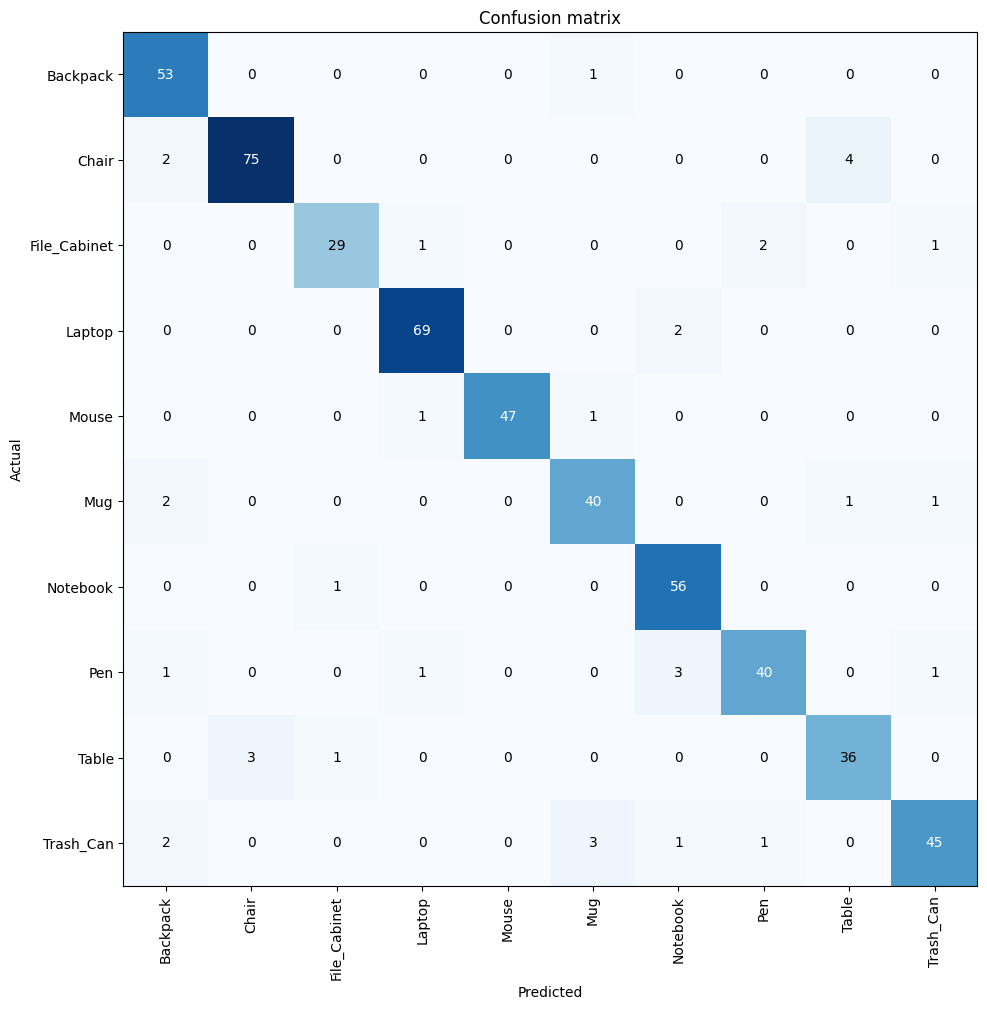

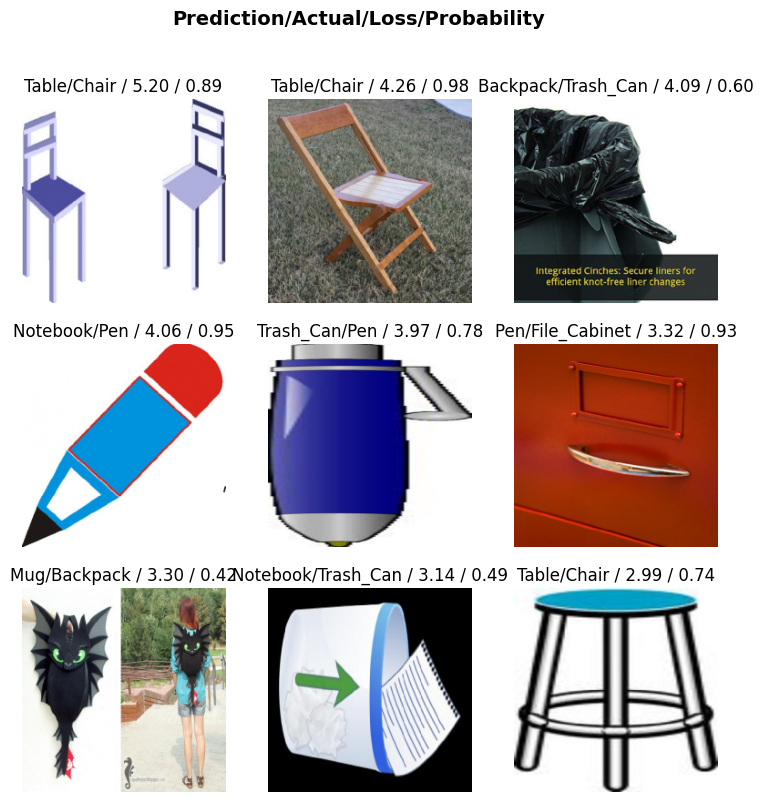

In [11]:
#plot confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(10,10))
interp.plot_top_losses(9, nrows=3)

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
import pandas as pd
import numpy as np

# Get predictions
preds, targs = learn.get_preds()

# Convert probabilities to class indices
pred_classes = preds.argmax(dim=1)
true_classes = targs

# Get class labels
labels = learn.dls.vocab

# Compute metrics
f1 = f1_score(true_classes, pred_classes, average='weighted')
precision = precision_score(true_classes, pred_classes, average='weighted')
recall = recall_score(true_classes, pred_classes, average='weighted')


print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)


F1 Score: 0.9296584641805326
Precision: 0.9312236826679343
Recall: 0.9297912713472486


In [13]:
# save model
learn.export('model.pkl')